# fMRI data analysis 
In this exercise, we will analyse the time series of one voxel in an fMRI experiment. During this experiment, we presented the subject color images and their black and white version. Hence, the stimulus consisted of two events, here referred to as ev1 and ev2. We will run a GLM analysis to test if, and how well, our stimulus can explain the variance of the data and to tell if the voxel responded more to color or black and white stimuli.

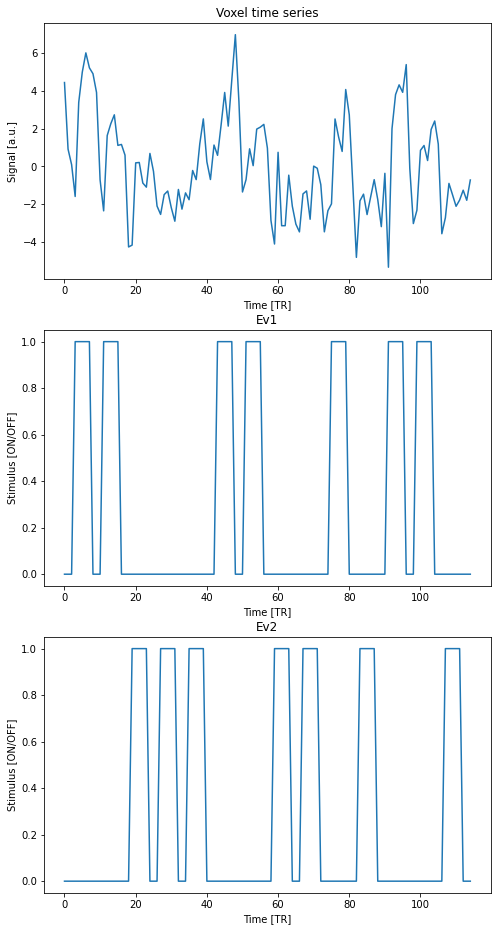

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Load time series of one voxel and stimulus timing
y = np.loadtxt(fname='data/fmri_timeseries.txt')
ev1 = np.loadtxt(fname='data/ev1_timing.txt')
ev2 = np.loadtxt(fname='data/ev2_timing.txt')

# Define TR and the number of acquired time points
TR = 2.5;
ntps = y.shape[0];

# View
plt.rcParams['figure.figsize'] = [8, 16]
plt.subplot(3,1,1)
plt.plot(y)
plt.title('Voxel time series')
plt.xlabel('Time [TR]')
plt.ylabel('Signal [a.u.]')
plt.subplot(3,1,2)
plt.plot(ev1)
plt.title('Ev1')
plt.xlabel('Time [TR]')
plt.ylabel('Stimulus [ON/OFF]')
plt.subplot(3,1,3)
plt.plot(ev2)
plt.title('Ev2')
plt.xlabel('Time [TR]')
plt.ylabel('Stimulus [ON/OFF]');

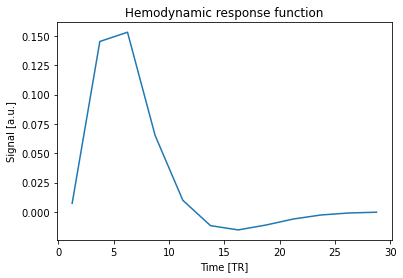

In [3]:
# Create hrf

t = np.arange(TR/2,30,TR)
A1 = 0.0083333333
A2 = 1.274527e-13
P1 = 5
P2 = 15

hrf = np.exp(-t) * (A1 * t ** P1 - A2 * t ** P2)

plt.rcParams['figure.figsize'] = [6,4]
plt.plot(t,hrf)
plt.xlabel('Time [TR]')
plt.ylabel('Signal [a.u.]')
plt.title('Hemodynamic response function');

## Ex. #01: Predicted time series

We want to create the expected response to our stimulus. The hemodynamic response function represents the system response to a Dirac delta stimulus. Hence, we need to convolve our stimulus with the hrf to obtain the predicted time series. Do it for both ev1 and ev2.
The call to compute the convolution between two vectors is:

`out = np.convolve(a,b)`
 
 Remember that the convolution operation creates a vector which is longer than our original time series so we need to cut it to the correct dimension.

In [4]:
# Solution
# Convolve ev1 with hrf and cut series
ev1_predicted = np.convolve(ev1,hrf)
ev1_predicted = ev1_predicted[0:ntps]

# Convolve ev2 with hrf and cut series
ev2_predicted = np.convolve(ev2,hrf)
ev2_predicted = ev2_predicted[0:ntps]

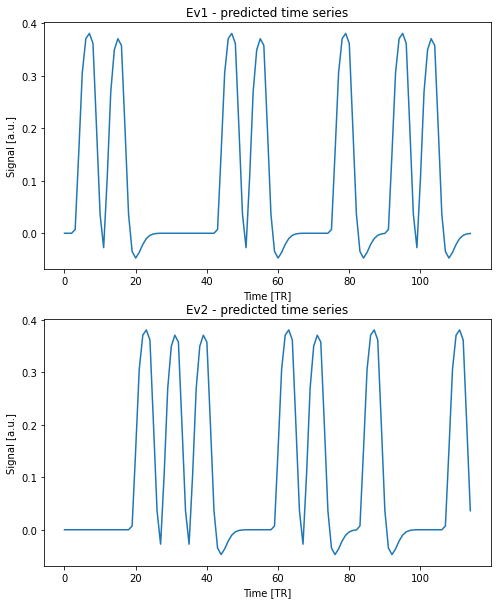

In [5]:
# View
plt.rcParams['figure.figsize'] = [8, 10]
plt.subplot(2,1,1)
plt.plot(ev1_predicted)
plt.title('Ev1 - predicted time series')
plt.xlabel('Time [TR]')
plt.ylabel('Signal [a.u.]')
plt.subplot(2,1,2)
plt.plot(ev2_predicted)
plt.title('Ev2 - predicted time series')
plt.xlabel('Time [TR]')
plt.ylabel('Signal [a.u.]');

## Ex. #02: General linear model (GLM)

Now we stack the predicted time series to create the design matrix X. The system we want to solve is the following: $$y = X  \beta + \epsilon $$

Compute the $\beta$ coefficients and compute the fitted time series. The call to compute the pseudoinverse of a matrix is:

`out = np.linalg.pinv(input)`

The call to compute matrix multiplication is:

`out = np.matmul(x,y)`

Then, compute $r^2$ using the following: $$r^2 = 1 - \frac{ss(\epsilon)}{ss(y)}$$


In [8]:
# Create design matrix with the variables of interest
X = np.stack((ev1_predicted,ev2_predicted),axis=1)

In [9]:
# Solution
# Compute design matrix pseudoinverse
Xinv = np.linalg.pinv(X)

# Compute beta coefficients
beta = np.matmul(Xinv,y)

# Compute fitted time series
fitted_timeseries = np.matmul(X,beta)

# Compute residuals epsilon
epsilon = y - fitted_timeseries

# Compute r2
r2 = 1 - sum(epsilon**2)/sum(y**2)

# Print beta coefficients and r2
print(beta)
print(r2)

[ 8.60982081 -3.43428349]
0.4529701946247222


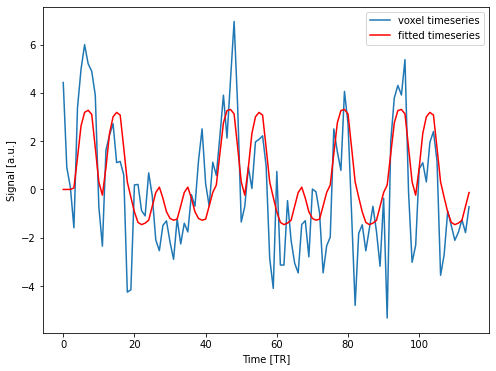

In [10]:
# View
plt.rcParams['figure.figsize'] = [8,6]
plt.plot(y) 
plt.plot(fitted_timeseries, 'r')
plt.xlabel('Time [TR]')
plt.ylabel('Signal [a.u.]')
plt.legend(['voxel time series','fitted time series']);

## Ex. #03: GLM with covariates

Now we will add nuisance variables that will allow us to obtain a better fit. These variables can include polynomials of various degrees, motion parameters, physiological data such as cardiac and respiratory waveform, etc. In this case, we will just include the intercept (constant offset) and a linear drift.

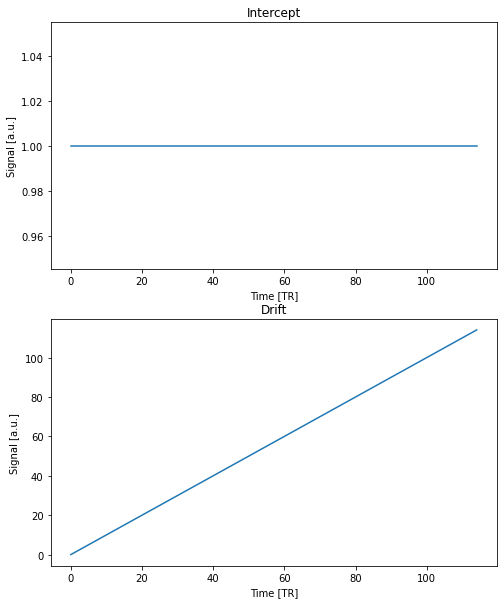

In [11]:
# Create covariates (intercept and drift)
intercept = np.ones((ntps,))
drift = np.arange(0,ntps)

# View
plt.rcParams['figure.figsize'] = [8,10]
plt.subplot(2,1,1)
plt.plot(intercept)
plt.title('Intercept')
plt.xlabel('Time [TR]')
plt.ylabel('Signal [a.u.]');
plt.subplot(2,1,2)
plt.plot(drift)
plt.title('Drift')
plt.xlabel('Time [TR]')
plt.ylabel('Signal [a.u.]');

## ================================================
Repeat GLM analysis after adding these nuisance variables to the design matrix. Look at the result. How did it change?

Do this voxel respond more to ev1 or to ev2?

In [12]:
# Create design matrix with variables of interest and covariates
X = np.stack((intercept,drift,ev1_predicted,ev2_predicted),axis=1)

# Run GLM
Xinv = np.linalg.pinv(X)
beta = np.matmul(Xinv,y)
fitted_timeseries = np.matmul(X,beta)

epsilon = y - fitted_timeseries
r2 = 1 - sum(epsilon**2)/sum(y**2)

# Print beta coefficients and r2
print(beta)
print(r2)

[-0.61160813 -0.01671615 13.61415792  1.83836958]
0.6184322237021622


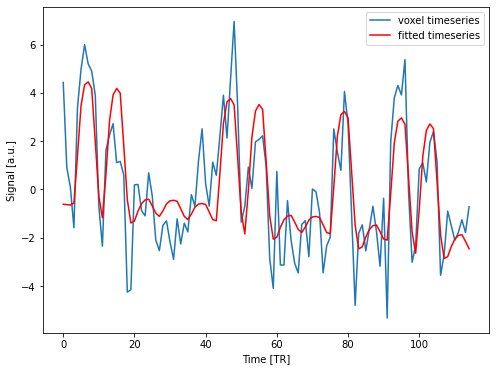

In [137]:
# View
plt.rcParams['figure.figsize'] = [8,6]
plt.plot(y) 
plt.plot(fitted_timeseries, 'r')
plt.xlabel('Time [TR]')
plt.ylabel('Signal [a.u.]')
plt.legend(['voxel timeseries','fitted timeseries']);